# Shared unit ratio figures

In [1]:
import sqlite3, json
import pandas as pd
from tokenizers import Tokenizer

In [2]:
# Load the list of protein sequences
db_file = "/cta/share/users/uniprot/human/human.db"
conn = sqlite3.connect(db_file)
df_uniprot_human_seqs = pd.read_sql(f"SELECT Sequence FROM proteins WHERE Entry IN (SELECT uniprot_accession FROM uniref50_distilled)", conn)
conn.close()
filtered_sequences = df_uniprot_human_seqs[
    (df_uniprot_human_seqs["Sequence"].str.count("X") <= 1) &
    (df_uniprot_human_seqs["Sequence"].str.count("B") <= 1) &
    (df_uniprot_human_seqs["Sequence"].str.count("U") <= 1) &
    (df_uniprot_human_seqs["Sequence"].str.count("Z") <= 1) &
    (df_uniprot_human_seqs["Sequence"].str.len() <= 3000)
]["Sequence"].tolist()

In [3]:
from collections import Counter
import numpy as np
x = 800 * (2 ** np.arange(0, 7))
puma_used_ratios = []
bpe_used_ratios = []
common_ratios = []
for v_size in x:
    # Requires models trained with multiprocess_train.py
    tkz_path = f"/cta/share/users/mutbpe/tokenizers/blosum62/hf_uniref50_mutbpe_0.7_3_12_0.05_{v_size}.json"
    vocab_path = f"/cta/share/users/mutbpe/tokenizers/blosum62/uniref50_mutbpe_0.7_3_12_0.05_{v_size}.json"
    puma_tkz = Tokenizer.from_file(tkz_path)
    with open(vocab_path) as f:
        puma_vocab = json.load(f)

    tkz_path = f"/cta/share/users/mutbpe/tokenizers/blosum62/hf_uniref50_bpe_{v_size}.json"
    vocab_path = f"/cta/share/users/mutbpe/tokenizers/blosum62/uniref50_bpe_{v_size}.json"
    bpe_tkz = Tokenizer.from_file(tkz_path)
    with open(vocab_path) as f:
        bpe_vocab = json.load(f)

    bpe_set = set(bpe_vocab.keys())
    puma_set = set(puma_vocab.keys())
    common_set = bpe_set.intersection(puma_set)
    common_ratios.append(len(common_set)/v_size)

    bpe_encs = bpe_tkz.encode_batch(filtered_sequences)
    puma_encs = puma_tkz.encode_batch(filtered_sequences)
    bpe_used = []
    puma_used = []

    for bpe_enc, puma_enc in zip(bpe_encs, puma_encs):
        bpe_used += bpe_enc.tokens
        puma_used += puma_enc.tokens

    bpe_counts = Counter(bpe_used)
    puma_counts = Counter(puma_used)
    common_sum = 0
    for tk, count in bpe_counts.items():
        if tk in common_set:
            common_sum += count
    puma_used_ratios.append(common_sum/len(puma_used))
    common_sum = 0
    for tk, count in puma_counts.items():
        if tk in common_set:
            common_sum += count
    bpe_used_ratios.append(common_sum/len(bpe_used))

bpe_used_ratios = np.array(bpe_used_ratios)
puma_used_ratios = np.array(puma_used_ratios)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


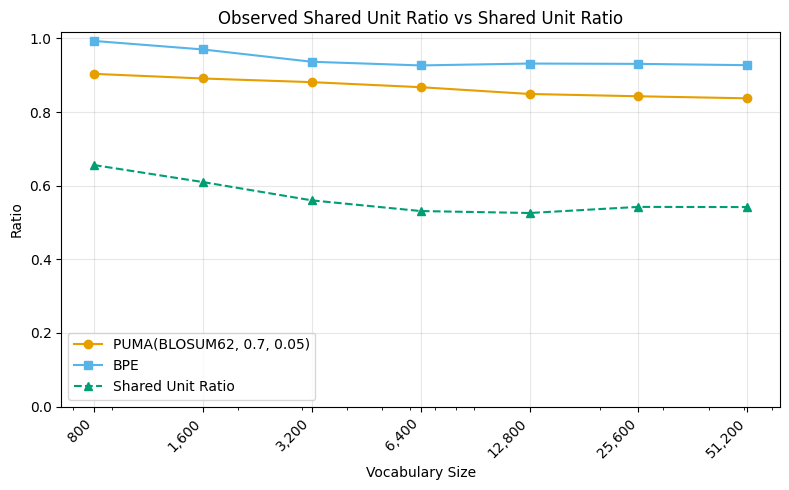

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



# Colorblind-friendly palette (Okabe-Ito)
colors = {
    "puma": "#E69F00",   # orange
    "bpe": "#56B4E9",    # sky blue
    "common": "#009E73"  # bluish green
}

plt.figure(figsize=(8, 5))

plt.plot(x, puma_used_ratios, marker="o", color=colors["puma"], label="PUMA(BLOSUM62, 0.7, 0.05)")
plt.plot(x, bpe_used_ratios, marker="s", color=colors["bpe"], label="BPE")
plt.plot(x, common_ratios, marker="^", ls="--", color=colors["common"], label="Shared Unit Ratio")

plt.xscale("log")
plt.xticks(800 * (2**np.arange(0, 7)), labels=[f"{v:,}" for v in x], rotation=45, ha="right")  # ensure ticks match your v_size values
plt.xlabel("Vocabulary Size")
plt.ylabel("Ratio")
plt.title("Observed Shared Unit Ratio vs Shared Unit Ratio")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(bottom=0)

plt.tight_layout()
# plt.savefig("shared_units.eps")
plt.show()
